We start by fetching the shape of Brandenburg from OpenStreetMap:

In [2]:
import geopandas as gp

In [3]:
search_url = 'https://nominatim.openstreetmap.org/search/?q=Brandenburg,%20Germany&format=geojson&polygon_geojson=1'
brandenburg = gp.read_file(search_url)[:1]
brandenburg

place_id  osm_type  osm_id              display_name  place_rank  \
0  234763399  relation   62504  Brandenburg, Deutschland           8   

   category            type  importance  \
0  boundary  administrative    0.766083   

                                                icon  \
0  https://nominatim.openstreetmap.org/images/map...   

                                            geometry  
0  MULTIPOLYGON (((11.26623 53.12205, 11.26780 53...

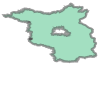

In [4]:
brandenburg.iloc[0]['geometry']

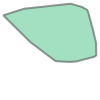

In [5]:
# let's remove the hole and simplify the shape
brandenburg_simple = brandenburg.convex_hull[0]
brandenburg_simple

Lets fetch products of interest from Scihub:

In [7]:
from sentinelsat import SentinelAPI
from datetime import date
import datetime

In [8]:
# --------------------------------------------------------------------------#
# adjust these lines to search for pictures of the fire you want to look at #
# you should not need to changed anything below this cell                   #
# --------------------------------------------------------------------------#
start_date = date(2020,6,20) - datetime.timedelta(weeks=4)
end_date = date(2020,6,20)
footprint = brandenburg_simple.wkt

In [9]:
# you need to set up the ~/.netrc in order for this login to work
api = SentinelAPI(None, None)

# the "footprint" is what we can use to preselect a certain area;
# the lake is at (51.7874, 14.4226)
# footprint = 'POLYGON((14.359428613281251 51.806620319822734,14.466545312500001 51.806620319822734,14.466545312500001 51.757343872357566,14.359428613281251 51.757343872357566,14.359428613281251 51.806620319822734))'

In [10]:
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=(0,30))

In [11]:
print('Found ' + str(len(products)) + ' results')

Found 56 results


## Is our entire footprint covered by the search results?

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


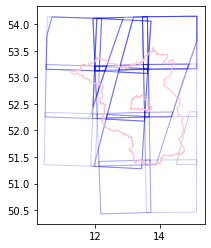

In [13]:
results = api.to_geodataframe(products)

ax = results.plot(color='', edgecolor='blue', alpha=0.2)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

The previous approach was this:

> We're picking our product by the following criteria:
>
> - It should be taken on the same date
> - It should only use one projection
> - It should have only a low cloud covoer percentage

But now we need to screw the same projection part. The new approach looks like this:

- Group pictures by day
- Use the ones with the lowest cloud cover percentage

In [14]:
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [15]:
results_per_day = results.groupby(results['ingestiondate'].dt.strftime('%Y-%m-%d')).count()['title']
most_results_per_day = results_per_day.sort_values(ascending=False).head(3)
most_results_per_day

ingestiondate
2020-06-16    12
2020-06-02    10
2020-05-31     7
Name: title, dtype: int64

Do those days cover our entire footprint?

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


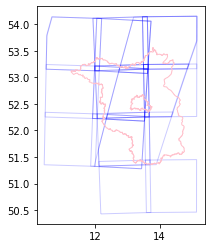

In [16]:
most_result_dates = set(most_results_per_day.index)

ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d').isin(most_result_dates)].plot(color='', edgecolor='blue', alpha=0.2)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

<span style='color: #f00'>**OOPS**</span> The top left corner is sometimes missing (ex. taking 7 August).

Nicey. Does one day cover all?

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


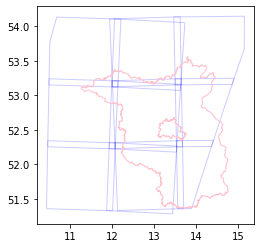

In [17]:
ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d') == '2020-06-16'].plot(color='', edgecolor='blue', alpha=0.2)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


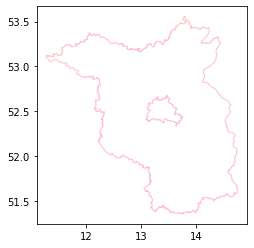

In [18]:
ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d') == '2020-06-22'].plot(color='', edgecolor='blue', alpha=0.2)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


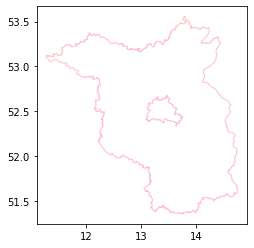

In [19]:
ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d') == '2020-06-27'].plot(color='', edgecolor='blue', alpha=0.2)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

Hmmm… that's not really ideal, is it? Let's take another approach and see for each date, regardless of how many results we have.

On 2020-06-17


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


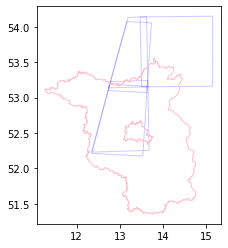

On 2020-06-16


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


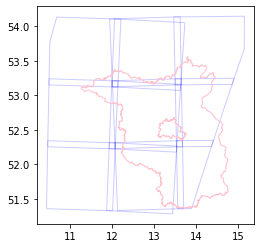

On 2020-06-13


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


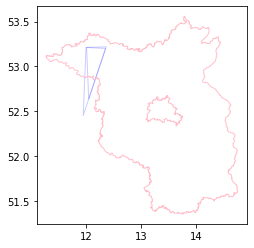

On 2020-06-12


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


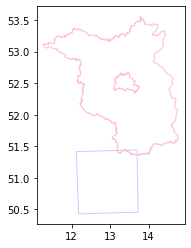

On 2020-06-03


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


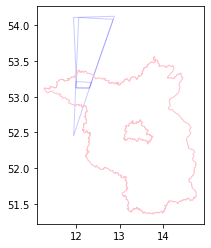

On 2020-06-02


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


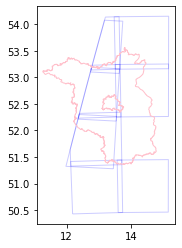

On 2020-05-31


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


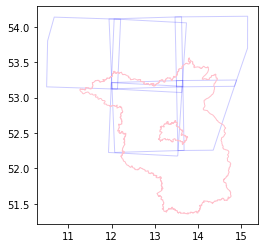

On 2020-05-30


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


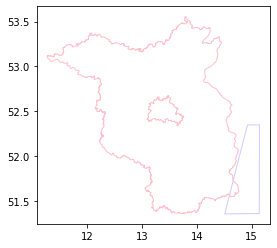

On 2020-05-29


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


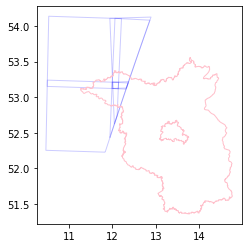

On 2020-05-28


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


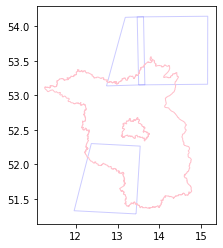

On 2020-05-26


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


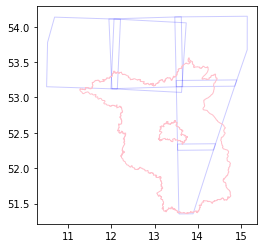

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

formatted = results['ingestiondate'].dt.strftime('%Y-%m-%d')
dates = formatted.unique()
for d in dates:
    on_this_date = results[formatted == d]
    print('On ' + d)
    ax = on_this_date.plot(color='', edgecolor='blue', alpha=0.2)
    brandenburg.plot(ax=ax, color='', edgecolor='pink')
    plt.savefig(d + '.svg')
    plt.show()

In [21]:
# let's just pick 16th and 22nd
to_download = {k: p for k, p in products.items() if p['ingestiondate'].date() in {date(2020, 6, 16), date(2020, 6, 22)}}

In [22]:
# TODO: Clean this up; at the moment we don't use cloud cover as a metric, but we might later
# Maybe something like "the most recent image without cloud cover" makes sense? And then compare Berlin
# and the whole area of Brandenburg?
# let's pick between 16th, 22nd and 27th

def calc_cloudcover(products):
    cloudcover = [v['cloudcoverpercentage'] for v in products]
    return sum(cloudcover) / len(products)

calc_cloudcover(to_download.values())

11.736200083333335

In [23]:
# we create the directory structure we need for the following notebooks
! mkdir -p input/raster/brandenburg_mosaic

In [24]:
print('Downloading {} files…'.format(len(to_download)))

In [25]:
downloaded, _, _ = api.download_all(to_download, 'input/raster/brandenburg_mosaic')
downloaded_paths = [d['path'] for d in downloaded.values()]

## Previewing Downloaded Files

In [26]:
from pathlib import Path

import rasterio as r
from rasterio import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
Path(downloaded_paths[1]).name

'S2B_MSIL2A_20200615T101559_N0214_R065_T33UUT_20200615T141117.zip'

In [28]:
import zipfile

def band_paths(p, bands, resolution=None):
    '''
    Given a zip file at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    The returned paths are formatted in the zip scheme as per Apache Commons VFS and can
    thus be directly opened by rasterio.
    '''
    with zipfile.ZipFile(p) as f:
        files = f.namelist()
        rasters = [f for f in files if f.endswith('.jp2')]
        rasters = ['zip+file://' + p + '!/' + r for r in rasters for b in bands if b in r and (not resolution or resolution in r)]
        return rasters

In [29]:
def rgb_paths(zip_file, resolution='10m'):
    return band_paths(zip_file, ['B02', 'B03', 'B04'], resolution)

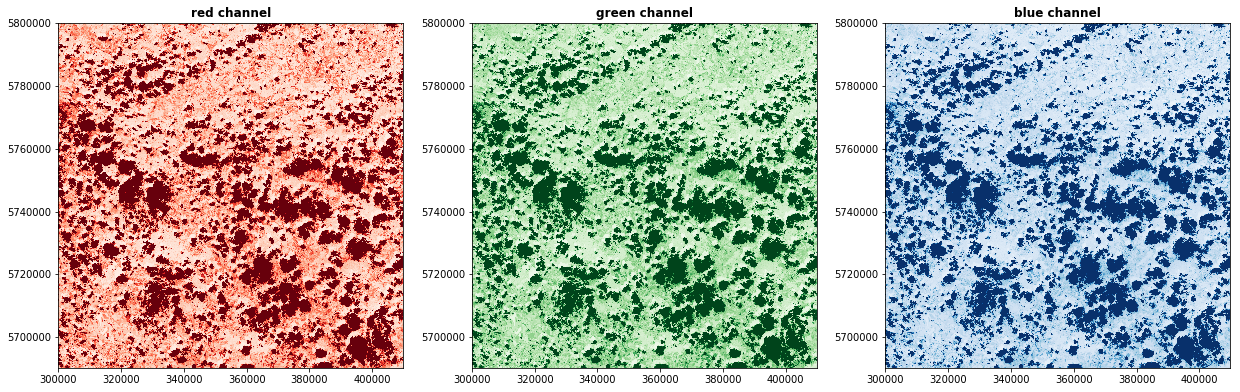

In [30]:
# preview the first downloaded image
with r.open(band_paths(downloaded_paths[1], ['TCI'], '20m')[0]) as true_color:
    # we do not need
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
    plot.show((true_color, 1), ax=axr, cmap='Reds', title='red channel')
    plot.show((true_color, 2), ax=axg, cmap='Greens', title='green channel')
    plot.show((true_color, 3), ax=axb, cmap='Blues', title='blue channel')
    plt.show()

In [31]:
# plotting the combined rgb image
true_color = r.open(band_paths(downloaded_paths[1], ['TCI'], '20m')[0])

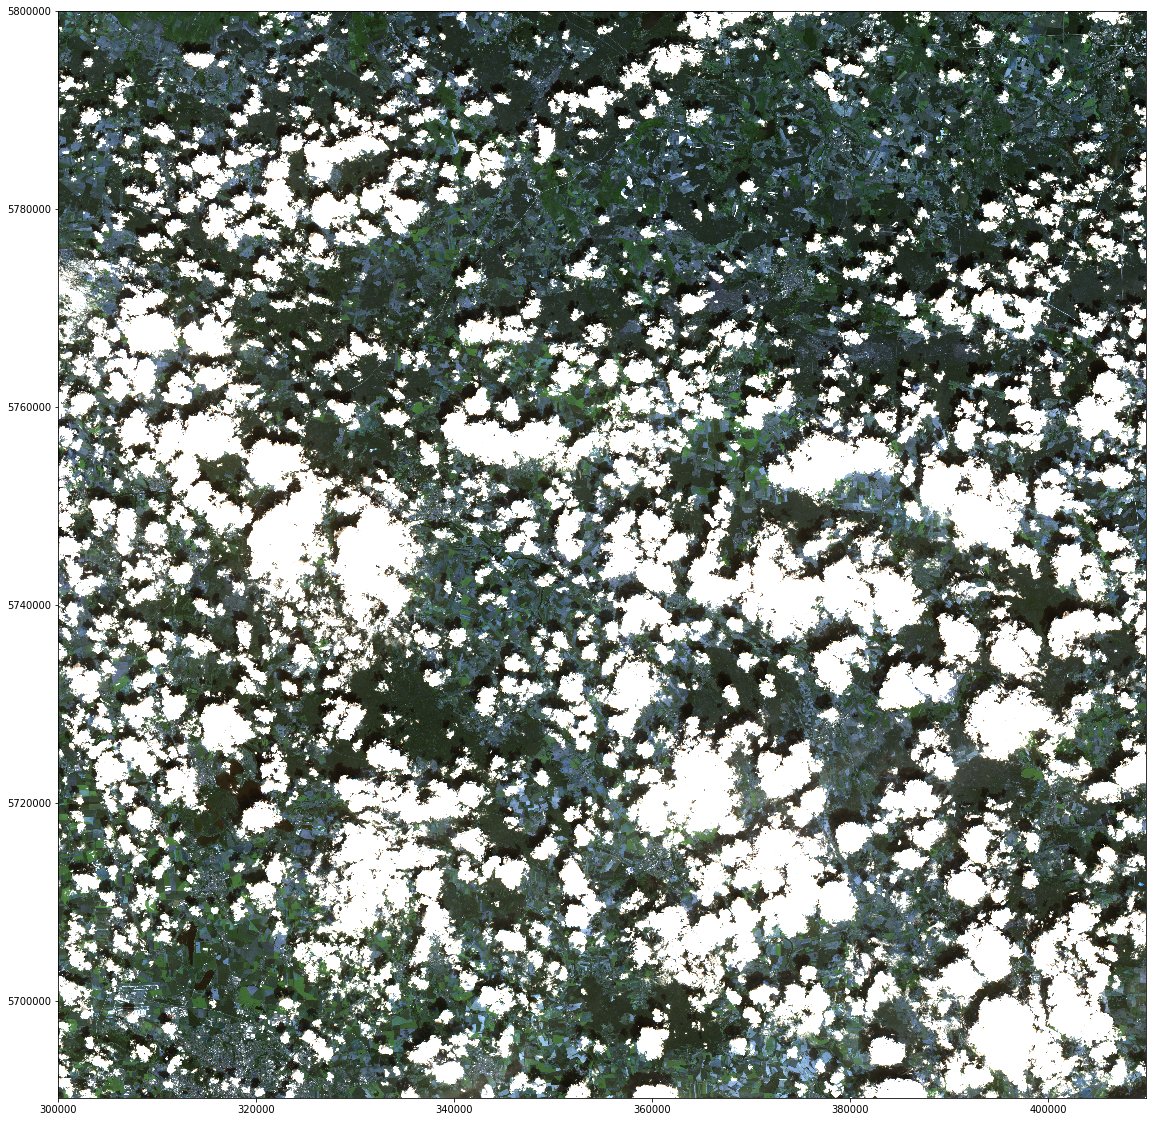

In [32]:
# note that in order to get the real colors, we need to reverse the bands into "rasterio band order"
plt.figure(figsize=(20,20))
plot.show(true_color.read()[::-1], transform=true_color.transform)
plt.show()

## Creating a True-Color Mosaic

In [33]:
from rasterio.merge import merge

### T32

In [34]:
test = [r.open(band_paths(f, ['TCI'], '60m')[0]) for f in downloaded_paths[:-1] if 'T32' in f]
test

[<open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQD_20200615T141117.zip!/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQD_20200615T141117.SAFE/GRANULE/L2A_T32UQD_A017108_20200615T101946/IMG_DATA/R60m/T32UQD_20200615T101559_TCI_60m.jp2' mode='r'>,
 <open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQC_20200615T141117.zip!/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQC_20200615T141117.SAFE/GRANULE/L2A_T32UQC_A017108_20200615T101946/IMG_DATA/R60m/T32UQC_20200615T101559_TCI_60m.jp2' mode='r'>,
 <open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQE_20200615T141117.zip!/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQE_20200615T141117.SAFE/GRANULE/L2A_T32UQE_A017108_20200615T101946/IMG_DATA/R60m/T32UQE_20200615T101559_TCI_60m.jp2' mode='r'>,
 <open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_2

In [35]:
test_mosaic, test_trans = merge(test)

In [36]:
src_meta = test[0].meta
src_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1830,
 'height': 1830,
 'count': 3,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(60.0, 0.0, 699960.0,
        0.0, -60.0, 5900040.0)}

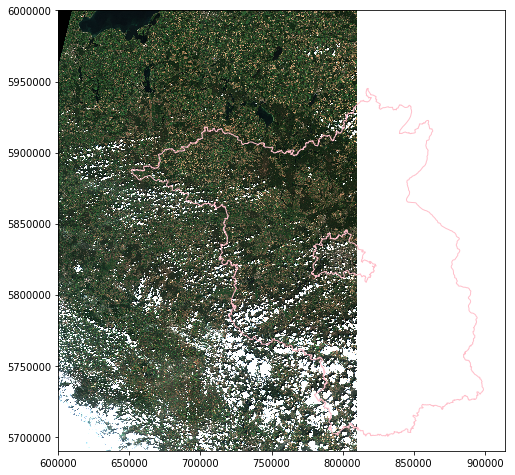

In [37]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,16))
plot.show(test_mosaic, transform=test_trans, ax=ax)
brandenburg.to_crs(src_meta['crs']).plot(ax=ax, color='', edgecolor='pink')
plt.show()

### T33

In [38]:
test = [r.open(band_paths(f, ['TCI'], '60m')[0]) for f in downloaded_paths[:-1] if 'T33' in f]
test

[<open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T33UVV_20200615T141117.zip!/S2B_MSIL2A_20200615T101559_N0214_R065_T33UVV_20200615T141117.SAFE/GRANULE/L2A_T33UVV_A017108_20200615T101946/IMG_DATA/R60m/T33UVV_20200615T101559_TCI_60m.jp2' mode='r'>,
 <open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T33UUT_20200615T141117.zip!/S2B_MSIL2A_20200615T101559_N0214_R065_T33UUT_20200615T141117.SAFE/GRANULE/L2A_T33UUT_A017108_20200615T101946/IMG_DATA/R60m/T33UUT_20200615T101559_TCI_60m.jp2' mode='r'>,
 <open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_20200615T141117.zip!/S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_20200615T141117.SAFE/GRANULE/L2A_T33UUU_A017108_20200615T101946/IMG_DATA/R60m/T33UUU_20200615T101559_TCI_60m.jp2' mode='r'>,
 <open DatasetReader name='zip+file://input/raster/brandenburg_mosaic/S2B_MSIL2A_2

In [39]:
test_mosaic, test_trans = merge(test)

In [40]:
src_meta = test[0].meta
src_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1830,
 'height': 1830,
 'count': 3,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(60.0, 0.0, 399960.0,
        0.0, -60.0, 6000000.0)}

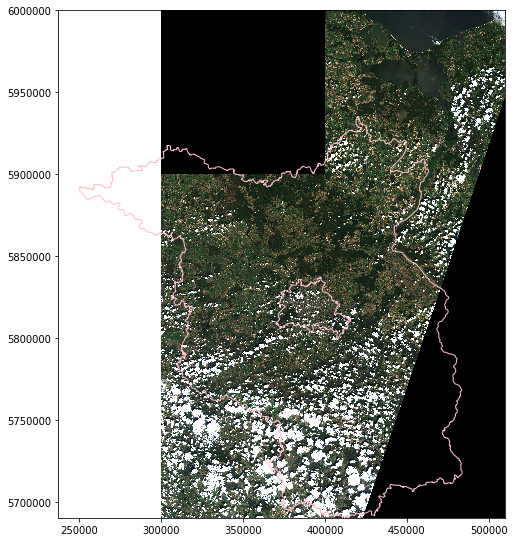

In [41]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,16))
plot.show(test_mosaic, transform=test_trans, ax=ax)
brandenburg.to_crs(src_meta['crs']).plot(ax=ax, color='', edgecolor='pink')
plt.show()

In [42]:
# coolcoolcool

In [43]:
from collections import Counter

In [53]:
# We define a RasterReaderList to read multiple raster files in one with-block;
# TODO: This is documented somewhere in the python docs, we should link to it here

class RasterReaderList():
    def __init__(self, paths):
        self.open_files = []
        self.paths = paths
    
    def __enter__(self):
        for f in self.paths:
            self.open_files.append(r.open(f))
        
        return self.open_files
    
    def __exit__(self, _type, _value, _traceback):
        for f in self.open_files:
            f.close()

In [45]:
# now we need to reproject all tiles to the same projection; for simplicity we take
# the projection that makes us do less work.

from rasterio.warp import calculate_default_transform, reproject, Resampling

In [51]:
reprojected_rasters = []

In [50]:
with RasterReaderList(band_paths(f, ['TCI'], '20m')[0] for f in downloaded_paths) as to_merge:
    most_common_crs, _ = Counter([str(f.crs) for f in to_merge]).most_common()[0]
    print('The most common CRS is', most_common_crs)
    
    for src in to_merge:
        # only reproject if necessary
        if str(src.meta['crs']) == most_common_crs:
            reprojected_rasters.append()
            continue
        
        # create a temporary file to write the output to
        tmp_output = Path('./tmp') / Path(src.name.replace('zip+file://', '').replace('.zip!', ''))
        tmp_path = str(tmp_output).replace(tmp_output.name, '')
        ! mkdir -p {tmp_path}
        
        print('tmp_path', tmp_path)
        
        # this is mostly taken from https://rasterio.readthedocs.io/en/latest/topics/reproject.html
        transform, width, height = calculate_default_transform(
            src.crs, most_common_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': most_common_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with r.open(tmp_output, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=r.band(src, i),
                    destination=r.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=most_common_crs,
                    resampling=Resampling.nearest)
                #print('Reprojected', dst.name)
            reprojected_rasters.append(tmp_output)

The most common CRS is EPSG:32633
tmp_path tmp/input/raster/brandenburg_mosaic/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQD_20200615T141117/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQD_20200615T141117.SAFE/GRANULE/L2A_T32UQD_A017108_20200615T101946/IMG_DATA/R20m/


NameError: name 'reprojected_rasters' is not defined

In [ ]:
to_merge

In [ ]:
mosaic, mosaic_transform = merge([r.open(band_paths(f, ['TCI'], '20m')[0]) for f in to_merge])

In [ ]:
plt.figure(figsize=(8,16))
plot.show(mosaic, transform=mosaic_transform)

In [ ]:
# we need to make sure both have the same CRS if we want to plot them on top of each other
src_meta = r.open(band_paths(downloaded_paths[0], ['TCI'], '60')[0]).meta
# src_meta

In [ ]:
# fig, (ax) = plt.subplots(1, 1, figsize=(8,16))
# plot.show(mosaic, transform=mosaic_transform, ax=ax)
# brandenburg.to_crs(src_meta['crs']).plot(ax=ax, color='', edgecolor='pink')
# plt.show()